In [111]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from numpy import *
from IPython.html.widgets import *
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Backpropagation Exercise

In this exercise, we will implement the backpropagation algorithm to train a simple neural network with a single hidden layer.

<img src="files/images/Backpropagation/diagram.png" style="margin:auto; width: 330px;"/>

# What is backpropagation?

Previously, we have derived the stochastic gradient decent rule for a single-layer network (perceptron).  (Error) backpropagation algorithm is a learning rule that lets us train feed-forward networks with more layers. 

## Notation

 * Input nodes: $ {\bf x} = (x_1, x_2, ... x_i)$
 * Hidden nodes: $ {\bf z} = (z_1, z_2, ... z_j)$
 * Output nodes: $ {\bf y} = (y_1, y_2, ... y_k)$

The input nodes are connected to the hidden nodes via weights $w^{(h)}_{ij}$, and hidden nodes to output nodes via $w^{(y)}_{jk}$.

### 1. Forward propagation

Given a particular input ${\bf x}$, we calculate the value (or **activation**) of a particular hidden node $z_j$ by taking the weighted sum of the inputs with $w^{(h)}_{ij}$ and passing it through an **activation function** $\sigma$:

$$ z_j = \sigma \left( \sum_i x_i w^{(h)}_{ij} \right)$$

The activation function is a *nonlinear* function.  A popular choice is a sigmoid family, for instance what's called the "funny tanh" function:

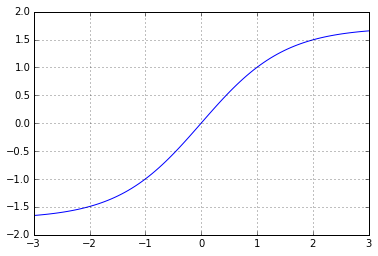

In [112]:
def funny_tanh(x):
    return 1.7159 * tanh(x*2/3)

xs=linspace(-3,3,100)
plt.plot(xs,funny_tanh(xs)); plt.grid()

We can calculate all values of the hidden nodes at once using the vector notation:

$$ {\bf z} = \sigma( {\bf x} \cdot W^{(h)} ) $$

And, similarly, the values of the output nodes are calculated as

$$ {\bf y} = \sigma( {\bf z} \cdot W^{(o)} ) $$

You can do the vector-matrix multiplication in `numpy` using the `dot` function, e.g. `dot(x, Wh)`.

This is called the **forward propagation** phase.

Exercise 1. Implement the feed-forward calculation.  Use `tanh` as the activation function $\sigma()$.

$$ {\bf z} = \sigma( {\bf x} \cdot W^{(h)} ) \\ {\bf y} = \sigma( {\bf z} \cdot W^{(o)} )$$

In [113]:
def feed_forward(x, Wh, Wo, activation_function=tanh):
    """Calculates the activations for the hidden and output nodes.
    
    inputs:
        x: N x I matrix, where each row is a particular observation.
        Wh: I x J matrix of hidden weights.
        Wo: J x K matrix of output weights.
        activation_function: the activation function to use.
    
    returns:
        z: N x J matrix of hidden activations.
        y: N x K matrix of output activations.
    """
    # TODO implement this
    N, I = x.shape
    J, K = Wo.shape
    return zeros((N, J)), zeros((N, K))

# Test to see if you implemented it correctly:
z, y = feed_forward(array([[1,2,3]]), ones((3,2))*.5, ones((2,1))*.3, activation_function=funny_tanh)
print(all(abs(z - array([[ 1.65417492, 1.65417492]])) < 1e-8))
print(all(abs(y - array([[ 0.99431892]])) < 1e-8))

False
False


In [116]:
# Sample solution:
def with_bias(x):
    return c_[x, ones((x.shape[0], 1))]

def feed_forward(x, Wh, Wo, activation_function=funny_tanh):
    """Calculates the activations for the hidden and output nodes.
    
    inputs:
        x: N x I matrix, where each row is a particular observation.
        Wh: I x J matrix of hidden weights.
        Wo: J x K matrix of output weights.
        activation_function: the activation function to use.
    
    returns:
        y: N x K matrix of output activations.
        z: N x J matrix of hidden activations.
    """
    z = activation_function(dot(with_bias(x), Wh))
    y = activation_function(dot(with_bias(z), Wo))
    return z, y

# Test to see if you implemented it correctly:
z, y = feed_forward(array([[1,2,3]]), ones((3,2))*.5, ones((2,1))*.3)
print(all(abs(z - array([[ 1.65417492, 1.65417492, 1.0]])) < 1e-8))
print(all(abs(y - array([[ 0.99431892, 1.0]])) < 1e-8))


ValueError: shapes (1,4) and (3,2) not aligned: 4 (dim 1) != 3 (dim 0)

### 2. Backward propagation

We then calculate "errors" associated with each node in the network.  This is called the **backward propagation** phase.
 
As was in the perceptron, the goal of the training is to change the weights $W^{(h)}, W^{(o)}$ so that the current output ${\bf y}$ will be closer to the target values ${\bf t}$.

 * For the output unit $y_k$, we define the "error" as $\delta^{(o)}_k = y_k - t_k$.
 * For the hidden unit $z_j$, we define the "error" as $\delta^{(h)}_j = \sigma' ({\bf x \cdot W^{(h)}}) \sum_k w^{(o)}_{jk} \delta^{(o)}_k$.

It looks a bit hairy, but it's conceptually simple:

 * For the output units, the error is positive (and proportional to) how much my prediction $y_k$ overshot the target $t_k$.
 * For the hidden units, the error is a *sum* of all the output unit errors it's connected to (*not* the input units).  
 
The delta of the hidden units are also multiplied by the derivative of the activation function (i.e. the slope of the activation function), because the "errors" (the $\delta$s) are actually partial derivatives of the loss function with respect to the weights.

<img src="files/images/Backpropagation/diagram2.png" style="margin:auto; width: 300px;"/>

Exercise 2: implement the routine to calculate the errors (deltas).

$$
    \delta^{(o)} = \underbrace{y - t}_{N \times K} \\
    \delta^{(h)} = \underbrace{\sigma' ({\bf x \cdot W^{(h)}})}_{N \times J} \times \underbrace{(\delta^{(o)} \cdot W^{(o)\intercal})}_{N \times J}
$$

Here, I've used the $\times$ symbol to denote the element-wise multiplication, which can be done by using the `multiply` function in NumPy.

In [ ]:
def approximate_derivative(f, x):
    """Return the (first-order) approximation of the derivative of f at x."""
    epsilon=1e-8
    return (f(x+epsilon) - f(x)) / epsilon

def calculate_deltas(error, x, Wh, Wo, activation_function=funny_tanh):
    """Calculates the delta values for the output and hidden nodes.
    
    inputs:
        y: N x K matrix of output activations.
        t: N x K matrix of target values.
        x: N x I matrix, where each row is a particular observation.
        Wh: I x J matrix of hidden weights.
        Wo: J x K matrix of output weights.
        activation_function: the activation function to use.
    
    returns:
        dh: N x J matrix of deltas for the hidden nodes.
        do: N x K matrix of deltas for the output nodes.
    """
    # TODO implement this
    N, K = y.shape
    I, J = Wh.shape
    return zeros((N, K)), zeros((I, J))

# Test to see if you implemented it correctly:
dh, do = calculate_deltas(array([[1]]), array([[2]]),
    array([[1,2,3]]), ones((3,2))*.5, ones((2,1))*.4)
print(do[0,0] == -1)
print(all(abs(dh - array([[-0.03232793,-0.03232793]])) < 1e-8))

In [117]:
# Sample solution:
def approximate_derivative(f, x):
    """Return the (first-order) approximation of the derivative of f at x."""
    epsilon=1e-8
    return (f(x+epsilon) - f(x)) / epsilon

def calculate_deltas(error, z, x, Wh, Wo, activation_function=funny_tanh):
    """Calculates the delta values for the output and hidden nodes.
    
    inputs:
        y: N x K matrix of output activations.
        t: N x K matrix of target values.
        x: N x I matrix, where each row is a particular observation.
        Wh: I x J matrix of hidden weights.
        Wo: J x K matrix of output weights.
        activation_function: the activation function to use.
    
    returns:
        dh: N x J matrix of deltas for the hidden nodes.
        do: N x K matrix of deltas for the output nodes.
    """
    do = multiply(approximate_derivative(activation_function, y), error)
    dh = multiply(approximate_derivative(activation_function, z), dot(do, Wo[:-1].T))
    return dh, do

# Test to see if you implemented it correctly:
dh, do = calculate_deltas(array([[1]]), array([[2]]),
    array([[1,2,3]]), ones((3,2))*.5, ones((2,1))*.4)
print(do[0,0] == -1)
print(all(abs(dh - array([[-0.03232793,-0.03232793]])) < 1e-8))

False
False


### 3. Weight update phase

After calculating all $\delta_k$ and $\delta_j$s, we update the weights using the stochastic gradient rule:

$$
 w^{(o)}_{jk} \leftarrow w^{(o)}_{jk} + \eta z_j \delta^{(o)}_k \\
 w^{(h)}_{ij} \leftarrow w^{(h)}_{ij} + \eta x_i \delta^{(h)}_j \\
$$

Note that the amount the weight changes is also modulated by the activation of the node: if a node had a large activation, weights associated with it is changed by a large amount, too. 

Exercise 3. Implement the routine to update the weights.

We can do the updates one sample observation $x_i$ at a time (online learning), or just use the average of the delta values (batch learning). For the batch learning, the update rule would be:

$$
 \underbrace{W^{(o)}}_{J \times K} \leftarrow W^{(o)} +  \frac{\eta}{N} \cdot \underbrace{{\bf z}^\intercal}_{K \times N} \cdot \underbrace{\delta^{(o)}}_{N \times K}  \\
 \underbrace{W^{(h)}}_{I \times J} \leftarrow W^{(h)} + \frac{\eta}{N} \cdot \underbrace{{\bf x}^\intercal}_{I \times N} \cdot \underbrace{\delta^{(h)}}_{N \times J} \\
$$

In [ ]:
def update_weights(Wh, Wo, z, do, x, dh, eta = 0.1):
    """Updates the hidden and output weights and return them.
    
    inputs:
        Wh: I x J matrix of hidden weights.
        Wo: J x K matrix of output weights.
        z: N x J matrix of hidden activations.
        do: N x K matrix of deltas for the output nodes.
        x: N x I matrix, where each row is a particular observation.
        dh: N x J matrix of deltas for the hidden nodes.
        eta: the learning rate to use.
    
    returns:
        updated Wh and Wo.
    """
    # TODO implement this
    return Wh, Wo

# Test to see if you implemented it correctly:
Wh, Wo = update_weights(Wh=ones((3,3))*.3, Wo=ones((3,2))*.5, 
                        z=array([[1,2,3]]), do=array([[1,2]]),
                        x=array([[1,2,3]]), dh=ones((1,3))*.4)

print(all(abs(Wh - array([[ 0.34, 0.34, 0.34], [0.38,  0.38,  0.38], [ 0.42,  0.42,  0.42]])) < 1e-8))
print(all(abs(Wo - array([[ 0.6, 0.7], [ 0.7, 0.9], [ 0.8, 1.1]])) < 1e-8))

In [ ]:
# Sample solution:
def update_weights(Wh, Wo, z, do, x, dh, eta = 0.1):
    """Updates the hidden and output weights and return them.
    
    inputs:
        Wh: I x J matrix of hidden weights.
        Wo: J x K matrix of output weights.
        z: N x J matrix of hidden activations.
        do: N x K matrix of deltas for the output nodes.
        x: N x I matrix, where each row is a particular observation.
        dh: N x J matrix of deltas for the hidden nodes.
        eta: the learning rate to use.
    
    returns:
        updated Wh and Wo.
    """
    N = x.shape[0]
    Wo = Wo + eta / N * dot(with_bias(z).T, do)
    Wh = Wh + eta / N * dot(with_bias(x).T, dh)
    return Wh, Wo 

# Test to see if you implemented it correctly:
Wh, Wo = update_weights(Wh=ones((3,3))*.3, Wo=ones((3,2))*.5, 
                        z=array([[1,2,3]]), do=array([[1,2]]),
                        x=array([[1,2,3]]), dh=ones((1,3))*.4)

print(all(abs(Wh - array([[ 0.34, 0.34, 0.34], [0.38,  0.38,  0.38], [ 0.42,  0.42,  0.42]])) < 1e-8))
print(all(abs(Wo - array([[ 0.6, 0.7], [ 0.7, 0.9], [ 0.8, 1.1]])) < 1e-8))

### Putting them all together

Now we just need to put them together and update the weight matrices until we get the desired performance out of the network.

In [ ]:
def bp_update_weights(Wh, Wo, x, t, activation_function=funny_tanh, eta=0.1):
    """Updates Wh, Wo and returns them from the traning set x and targets t."""
    z, y = feed_forward(x, Wh, Wo, activation_function=activation_function)
    dh, do = calculate_deltas(t-y, z, x, Wh, Wo, activation_function=activation_function)
    Wh, Wo = update_weights(Wh, Wo, z, do, x, dh, eta = eta)
    return Wh, z, Wo, y

In [ ]:
# Function to plot the network
def plot_nn(x, Wh, z, Wo, y):
    fig, ax = plt.subplots() 
    cmap = plt.get_cmap('RdBu')
    for i, x_ in enumerate(x.T):
        ax.add_artist(plt.Circle((1, -i-1), 0.25, ec='k', fc=cmap(x_[0]/2+.5)))
    
    for i, wi in enumerate(Wh):
        for j, w_ in enumerate(wi):
            ax.add_artist(plt.arrow(1.3, -i-1, 1.3, (i-j)*.9, head_width=0.05, head_length=0.1, ec=cmap(w_/2+.5)))

    for i, z_ in enumerate(z.T):
        ax.add_artist(plt.Circle((3, -i-1), 0.25, ec='k', fc=cmap(z_[0]/2+.5)))
        
    for i, wi in enumerate(Wo):
        for j, w_ in enumerate(wi):
            ax.add_artist(plt.arrow(3.3, -i-1, 1.3, (i-j)*.9, head_width=0.05, head_length=0.1, ec=cmap(w_/2+.5)))
        
    for i, y_ in enumerate(y.T):
        ax.add_artist(plt.Circle((5, -i-1), 0.25, ec='k', fc=cmap(y_[0]/2+.5)))
        
    m = max(x.shape + z.shape + y.shape)
    ax.set_xlim([0, 6])
    ax.set_ylim([-m-1,0])
    ax.set_aspect('equal')
    ax.axis('off')
plot_nn(array([[1.0,-1,1]]), -ones((3,3)), ones((1,3)), ones((3, 2)), zeros((1,2)))

Let's try training it to recognize the "XOR" pattern, and watch how it modifies the weights.

In [ ]:
X=array([
    [ 1,-1],
    [-1, 1],
    [ 1, 1],
    [-1,-1]], dtype=float)
T=array([
    [ 1],
    [ 1],
    [-1],
    [-1]], dtype=float)

# Initialize weights
J = 2 # Number of hidden units
from numpy.random import random_sample
Wh = random_sample((X.shape[1], J))
Wo = random_sample((J, T.shape[1]))
epoch = 0

def update_and_plot():
    global X, T, epoch, Wh, Wo
    # Train one example at a time (online learning)
    x = X[epoch % X.shape[0],newaxis]
    t = T[epoch % T.shape[0],newaxis]
    print('x=' + str(x))
    print('t=' + str(t))
    Wh, z, Wo, y = bp_update_weights(Wh, Wo, x, t)
    print('y=' + str(y))
    plot_nn(x, Wh, z, Wo, y)
    epoch += 1

interact_manual(update_and_plot)

We will then test it on the face data.

In [118]:
import pickle
dataset = pickle.load(open('data/cafe.pkl','r'))

from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split

def train(X, t, epochs = 100, n_input = 10, n_hidden = 40, 
        hidden_learning_rate = 0.1, output_learning_rate = 0.1, momentum_learning_rate = 0.9,          
        test_size=0.2, cv=3):
    """Initialize the network and start training."""

    # Initialize variables
    n_output = len(unique(t))
    Vh = zeros((n_input + 1, n_hidden))
    Wh = random_sample(Vh.shape)
    Vo = zeros((n_hidden + 1, n_output))
    Wo = random_sample(Vo.shape)

    # Convert to binary
    tb = ones((X.shape[0], n_output))*(-1.0)
    tb[arange(tb.shape[0]), t-1]=1.0
    
    # Split
    X_train, X_test, tb_train, tb_test = train_test_split(X, tb, test_size=test_size, random_state=0)

    # Preprocess the data using PCA
    pca = PCA(n_components = n_input, whiten=True, copy=True)
    Xw_train = pca.fit_transform(X_train)
    Xw_test = pca.transform(X_test)

    # Start the training
    rmse=zeros((epochs,2))
    cerr=zeros((epochs,2))
    for epoch in arange(epochs):

        # Test then Train, since we'll use the training errors
        for i, (Xw, tb_) in enumerate([[Xw_test, tb_test], [Xw_train, tb_train]]):
            z, y = feed_forward(Xw, Wh, Wo)
            errors = tb_ - y
            rmse[epoch, i] = sqrt((errors**2).mean())  # RMSE
            cerr[epoch, i] = (argmax(tb_,axis=1) != argmax(y,axis=1)).mean()

        yield rmse, cerr, epoch, epochs

        # Update weights using backpropagation
        Wh, z, Wo, y = bp_update_weights(Wh, Wo, Xw_train, tb_train)  # Note they come from the training data!

def plot_training(axs, rmse, cerr, t, epochs):
    """Draw the plot to the specified axis."""
    axs[0].set_title("RMSE")
    axs[0].set_xlabel("Training epoch")
    axs[0].set_ylabel("RMSE")
    axs[0].grid()

    axs[0].plot(arange(t), rmse[:t])
    axs[0].set_xlim([0, epochs])
    axs[0].set_ylim([0, 2.0])
    axs[0].legend(['Test', 'Training'], loc="best")

    axs[1].set_title("Classification Error")
    axs[1].set_xlabel("Training epoch")
    axs[1].set_ylabel("Classification Error Rate [\%]")
    axs[1].grid()

    axs[1].plot(arange(t), cerr[:t]*100.0)
    axs[1].set_xlim([0, epochs])
    axs[1].set_ylim([0, 100.0])
    axs[1].legend(['Test', 'Training'], loc="best")

def train_network(dataset, target_name, **kwargs):
    X = dataset.data
    t = dataset[target_name]
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    for rmse, cerr, epoch, epochs in train(X, t, **kwargs):
        if mod(epoch, 10) != 0:
            continue

        plot_training(axs, rmse, cerr, epoch, epochs)
        clear_output(wait=True)
        display(fig)
        axs[0].cla()
        axs[1].cla()

    plt.close()
    plot_training(axs, rmse, cerr, epoch, epochs)
    clear_output(wait=True)
    display(fig)

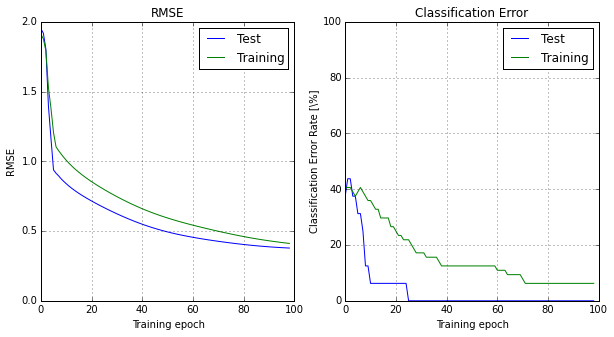

In [119]:
interact_manual(train_network,
    dataset=fixed(dataset),
    target_name={'Identity': 'target', 'Gender': 'gender', 'Expression': 'expression'},
    epochs= IntSlider(min=10, max=500, step=10, value=100),
    n_input = IntSlider(min=1, max=(dataset.data.shape[0]-1), value=40),
    n_hidden = IntSlider(min=1, max=40, value=10), 
    hidden_learning_rate = FloatSlider(min=0.01, max=0.3, value=0.1),
    output_learning_rate = FloatSlider(min=0.01, max=0.3, value=0.1),
    momentum_learning_rate = FloatSlider(min=0.5, max=0.99, value=0.9),         
    test_size=FloatSlider(min=0.1, max=0.5, value=0.2))